In [2]:
# uncomment if not installed
# pip install pyNetLogo

  Using cached pyNetLogo-0.4.2.tar.gz (58 kB)
  Created wheel for pyNetLogo: filename=pyNetLogo-0.4.2-py3-none-any.whl size=64604 sha256=183a8b320155885b9736f418ce354d24090efe78d415f46787d80f057e8fe022
  Stored in directory: c:\users\archipel-03\appdata\local\pip\cache\wheels\fa\5c\68\702aa26a9d2fbd249fe9c4c9d4d333e2baada598c3628e11fb
Successfully built pyNetLogo
Note: you may need to restart the kernel to use updated packages.


In [5]:
# uncomment if not installed
#pip install jpype1

Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, 
                           Constant, CategoricalParameter, 
                           IntegerParameter, perform_experiments, 
                           MultiprocessingEvaluator, ema_logging,
                           save_results)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import (plotting, plotting_util)

from ema_workbench.util.utilities import load_results

#### All input parameters and input possibilities

* EMA/pyNetLogo passes the string value as a raw text into NetLogo, as opposed to as a string. Single '' around the string solve the issue

|Parameter	|Range or value	| Parameter class |
|-----------|--------------|-----------------:|
|Final time	    |1560	    | run_length|
|GDP_change    |'"decreasing"', '"constant"', '"increasing"'	    | CategoricalParameter|
|w_demand_change	    |'"decreasing"', '"constant"', '"increasing"'	    |CategoricalParameter |
|regulations_change	    |'"decreasing"', '"constant"', '"increasing"'	    |CategoricalParameter |
|trust_agri_change	    |'"decreasing"', '"constant"', '"increasing"'    |CategoricalParameter |
|trust_gov_change	    |'"decreasing"', '"constant"', '"increasing"'	    |CategoricalParameter |
|know_dev_change	    |'"decreasing"', '"constant"', '"increasing"'	    |CategoricalParameter |
|GDP_change_r	    |'"gradual"', '"medium"', '"abrupt"'	    |CategoricalParameter |
|rainfall_change_r	    |'"gradual"', '"medium"', '"abrupt"'	    |CategoricalParameter |
|w_demand_change_r	    |'"gradual"', '"medium"', '"abrupt"'	    |CategoricalParameter |
|regulations_change_r	    |'"gradual"', '"medium"', '"abrupt"'	    |CategoricalParameter |
|trust_agri_change_r	    |'"gradual"', '"medium"', '"abrupt"'	    |CategoricalParameter |
|trust_gov_change_r	    |'"gradual"', '"medium"', '"abrupt"'	    |CategoricalParameter |
|know_dev_change_r	    |'"gradual"', '"medium"', '"abrupt"'	    |CategoricalParameter |
|No_consumers	    |4 - 100	    |IntegerParameter |
|No_farmers    |4 - 20	    |IntegerParameter |
|Leader_network_size	    |6 - 12	    |IntegerParameter |
|consumer_leaders    |0 - 0.25	    |RealParameter |
|farmer_leaders	    |0 - 0.25	    |RealParameter |
|leader_influence    |1 - 10	    |IntegerParameter |

#### Outcome parameters
|Outcomes	|Outcome class	
|-----------|--------------:|
|TIME	    |TimeSeriesOutcome	    |
|average_risk_consumers	    |TimeSeriesOutcome	    |
|average_benefit_consumers	    |TimeSeriesOutcome	    |
|average_risk_farmers	    |TimeSeriesOutcome	    |
|average_benefit_farmers	    |TimeSeriesOutcome	    |
|optimistic_consumers	    |TimeSeriesOutcome	    |
|conflicted_consumers	    |TimeSeriesOutcome	    |
|neutral_consumers	    |TimeSeriesOutcome	    |
|alarmed_consumers	    |TimeSeriesOutcome	    |
|optimistic_farmers	    |TimeSeriesOutcome	    |
|conflicted_farmers	    |TimeSeriesOutcome	    |
|neutral_farmers	    |TimeSeriesOutcome	    |
|alarmed_farmers	    |TimeSeriesOutcome	    |

In [46]:
# Create dictionary with the scenarios
scenarios = {"Base scenario" : [Constant('GDP_change', '"constant"'),
                                Constant('rainfall_change', '"constant"'),
                                Constant('w_demand_change', '"constant"'),
                                Constant('regulations_change', '"constant"'),
                                Constant('trust_agri_change', '"constant"'),
                                Constant('trust_gov_change', '"constant"'),
                                Constant('know_dev_change', '"constant"'),
                                Constant("No_consumers", 100),
                                Constant("No_farmers", 100)],
             "Easy does it" :  [Constant('GDP_change', '"constant"'),
                                Constant('rainfall_change', '"constant"'),
                                Constant('w_demand_change', '"increasing"'),
                                Constant('regulations_change', '"constant"'),
                                Constant('trust_agri_change', '"constant"'),
                                Constant('trust_gov_change', '"constant"'),
                                Constant('know_dev_change', '"constant"'),
                                Constant('w_demand_change_r', '"gradual"'),
                                Constant("No_consumers", 100),
                                Constant("No_farmers", 100)],
            "The young ones" : [Constant('GDP_change', '"increasing"'),
                                Constant('rainfall_change', '"constant"'),
                                Constant('w_demand_change', '"increasing"'),
                                Constant('regulations_change', '"constant"'),
                                Constant('trust_agri_change', '"constant"'),
                                Constant('trust_gov_change', '"constant"'),
                                Constant('know_dev_change', '"increasing"'),
                                Constant('know_dev_change_r', '"gradual"'),
                                Constant('w_demand_change_r', '"medium"'),
                                Constant('GDP_change_r', '"gradual"'),
                                Constant("No_consumers", 100),
                                Constant("No_farmers", 100)],
            "Of things past" : [Constant('GDP_change', '"decreasing"'),
                                Constant('rainfall_change', '"decreasing"'),
                                Constant('w_demand_change', '"decreasing"'),
                                Constant('regulations_change', '"constant"'),
                                Constant('trust_agri_change', '"decreasing"'),
                                Constant('trust_gov_change', '"decreasing"'),
                                Constant('know_dev_change', '"decreasing"'),
                                Constant('know_dev_change_r', '"gradual"'),
                                Constant('w_demand_change_r', '"medium"'),
                                Constant('GDP_change_r', '"abrupt"'),
                                Constant('rainfall_change_r', '"gradual"'),
                                Constant('trust_gov_change_r', '"abrupt"'),
                                Constant('trust_agri_change_r', '"gradual"'),
                                Constant("No_consumers", 100),
                                Constant("No_farmers", 100)],
    "Regulating things past" : [Constant('GDP_change', '"decreasing"'),
                                Constant('rainfall_change', '"decreasing"'),
                                Constant('w_demand_change', '"decreasing"'),
                                Constant('regulations_change', '"increasing"'),
                                Constant('trust_agri_change', '"decreasing"'),
                                Constant('trust_gov_change', '"decreasing"'),
                                Constant('know_dev_change', '"decreasing"'),
                                Constant('know_dev_change_r', '"gradual"'),
                                Constant('w_demand_change_r', '"medium"'),
                                Constant('GDP_change_r', '"abrupt"'),
                                Constant('rainfall_change_r', '"gradual"'),
                                Constant('trust_gov_change_r', '"abrupt"'),
                                Constant('trust_agri_change_r', '"gradual"'),
                                Constant('regulations_change_r', '"abrupt"'),
                                Constant("No_consumers", 100),
                                Constant("No_farmers", 100)],
             "Max overdrive" : [Constant('GDP_change', '"constant"'),
                                Constant('rainfall_change', '"decreasing"'),
                                Constant('w_demand_change', '"increasing"'),
                                Constant('regulations_change', '"constant"'),
                                Constant('trust_agri_change', '"decreasing"'),
                                Constant('trust_gov_change', '"constant"'),
                                Constant('know_dev_change', '"constant"'),
                                Constant('w_demand_change_r', '"abrupt"'),
                                Constant('rainfall_change_r', '"abrupt"'),
                                Constant('trust_agri_change_r', '"gradual"'),
                                Constant("No_consumers", 100),
                                Constant("No_farmers", 100)]
            }
                              
             

In [47]:
# Define function to get the median from nested lists per column
def column_median(lst):
      return [np.median(i) for i in zip(*lst)]

# Not sure if these will be used

# Define function to get the max from nested lists per column
def column_max(lst):
      return [np.max(i) for i in zip(*lst)]

# Define function to get the min from nested lists per column
def column_min(lst):
      return [np.min(i) for i in zip(*lst)]



In [48]:
ema_logging.log_to_stderr(ema_logging.INFO)

#We can define common uncertainties and outcomes for each model:
uncertainties = [IntegerParameter("Leader_network_size", 6, 12),
                 RealParameter("consumer_leaders", 0, 0.25),
                 RealParameter("farmer_leaders", 0, 0.25),
                 IntegerParameter("leader_influence", 1, 10),
                ] 

outcomes = [TimeSeriesOutcome('TIME'),
            TimeSeriesOutcome('average_risk_consumers'),
            TimeSeriesOutcome('average_benefit_consumers'), 
            TimeSeriesOutcome('average_risk_farmers'),
            TimeSeriesOutcome('average_benefit_farmers'),
            TimeSeriesOutcome('optimistic_consumers'),
            TimeSeriesOutcome('conflicted_consumers'),
            TimeSeriesOutcome('neutral_consumers'),
            TimeSeriesOutcome('alarmed_consumers'),
            TimeSeriesOutcome('optimistic_farmers'),
            TimeSeriesOutcome('conflicted_farmers'),
            TimeSeriesOutcome('neutral_farmers'),
            TimeSeriesOutcome('alarmed_farmers')
           ]
   

#Define the NetLogo model
nl_model = NetLogoModel('NetLogo', wd='./Netlogo/', 
                        model_file="Risk_benefit_model_exp_running.nlogo")
nl_model.run_length = 1560
nl_model.replications = 100
nl_model.uncertainties = uncertainties
nl_model.outcomes = outcomes
nr_experiments = 100

In [70]:
%%time  
try:
    all_experiments, all_outcomes = load_results("results/scenarios_results.tar.gz")
    # There is a bug in EMA workbench that converts dtype object to categorical 
    # when using load_results, so this is to convert any changes back to object
    # in case changes need to be made to the loaded results and saved again
    for i in all_experiments.select_dtypes(include=pd.CategoricalDtype).columns:
        all_experiments[i] = all_experiments[i].astype(str)
except IOError:
    # With 100 experiments and 100 replications it takes about 6,5 hours
    # Create empty dataframe and dictionary
    all_experiments = pd.DataFrame()
    all_outcomes = {}

    # iterate through the different scenarios
    for scenario in scenarios:
        nl_model.constants = scenarios[scenario]
        with MultiprocessingEvaluator(nl_model) as evaluator:
            experiments, outcomes = evaluator.perform_experiments(nr_experiments, 
                                                                  uncertainty_sampling=LHS)

        # Change scenario names  
        experiments["scenario"] = scenario
        # Concat all experiments together
        dfs = [all_experiments, experiments]
        all_experiments = pd.concat(dfs, ignore_index=True,)

        # Empty dictionaries evaluate to false
        # Concat all outcomes together as well
        if bool(all_outcomes):
            ds = [all_outcomes, outcomes]
            for k in outcomes.keys():
                all_outcomes[k] = np.concatenate(list(all_outcomes[k] for all_outcomes in ds))
        else:
            ds = [outcomes]
            for k in outcomes.keys():
                all_outcomes[k] = np.concatenate(list(all_outcomes[k] for all_outcomes in ds))
    
    # Get the median of the replications per experiment, and change the shape of the outcomes 
    # for plotting and reduction of file size
    for j in all_outcomes:
        big_list = []
        for i in all_outcomes[j]:
            median_array = np.asarray(column_median(i))
            big_list.append(median_array)
            all_outcomes[j] = np.asarray(big_list)

    save_results((all_experiments, all_outcomes), "results/scenarios_results.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\archipel-03\Documents\GitHub\Risk-Benefit_Model\results\scenarios_results.tar.gz


Wall time: 3.4 s


In [50]:
all_experiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Leader_network_size  600 non-null    float64
 1   consumer_leaders     600 non-null    float64
 2   farmer_leaders       600 non-null    float64
 3   leader_influence     600 non-null    float64
 4   scenario             600 non-null    object 
 5   policy               600 non-null    object 
 6   model                600 non-null    object 
dtypes: float64(4), object(3)
memory usage: 32.9+ KB


In [51]:
print(all_experiments.shape)
for k, v in all_outcomes.items():
    print(k, v.shape)

all_experiments

(600, 7)
TIME (600, 1561)
average_risk_consumers (600, 1561)
average_benefit_consumers (600, 1561)
average_risk_farmers (600, 1561)
average_benefit_farmers (600, 1561)
optimistic_consumers (600, 1561)
conflicted_consumers (600, 1561)
neutral_consumers (600, 1561)
alarmed_consumers (600, 1561)
optimistic_farmers (600, 1561)
conflicted_farmers (600, 1561)
neutral_farmers (600, 1561)
alarmed_farmers (600, 1561)


,Leader_network_size,consumer_leaders,farmer_leaders,leader_influence,scenario,policy,model
0,8.0,0.138903,0.165749,6.0,Base scenario,None,NetLogo
1,9.0,0.052441,0.140762,5.0,Base scenario,None,NetLogo
2,7.0,0.230088,0.002777,2.0,Base scenario,None,NetLogo
3,11.0,0.098679,0.127905,8.0,Base scenario,None,NetLogo
4,9.0,0.196854,0.153421,2.0,Base scenario,None,NetLogo
...,...,...,...,...,...,...,...
595,10.0,0.239094,0.121871,2.0,Max overdrive,None,NetLogo
596,10.0,0.058439,0.160115,2.0,Max overdrive,None,NetLogo
597,9.0,0.148908,0.199237,10.0,Max overdrive,None,NetLogo
598,9.0,0.029544,0.143732,1.0,Max overdrive,None,NetLogo


# Plotting the Result

## Consumers

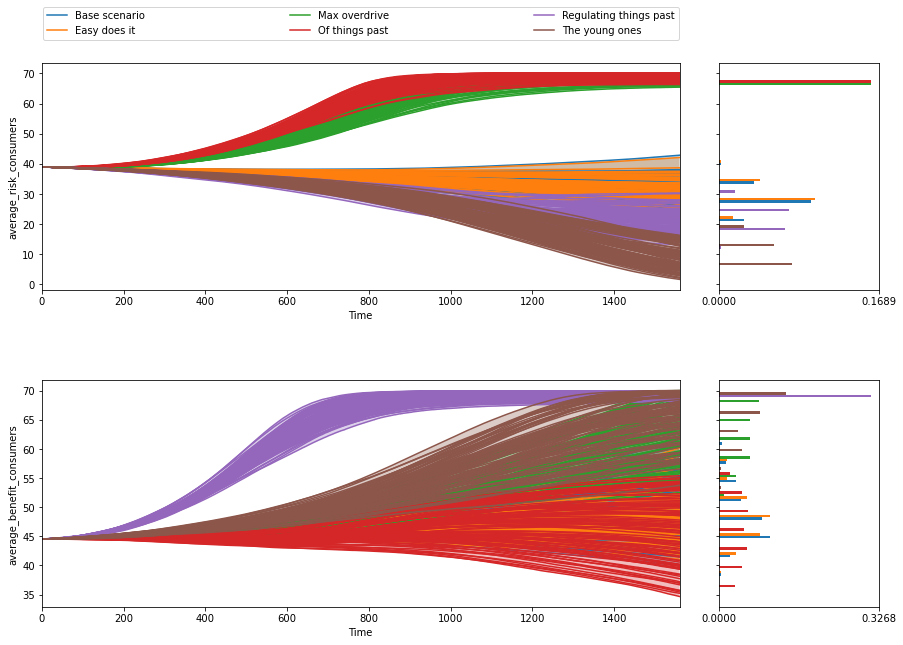

In [52]:
experiments_to_show = np.arange(0, all_experiments.shape[0], 1)

fig, ax = plotting.lines(all_experiments, 
                         all_outcomes, 
                         outcomes_to_show=['average_risk_consumers', 
                                           'average_benefit_consumers'], 
                         group_by='scenario',
                         show_envelope=True, 
                         density=plotting.Density.HIST, 
                         titles=None, 
                         experiments_to_show=experiments_to_show)

fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

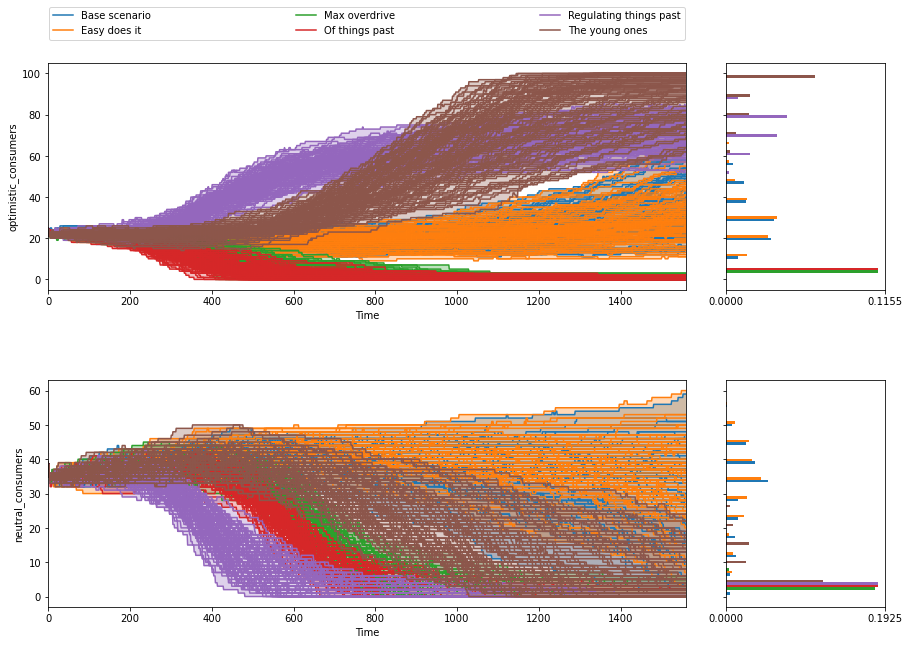

In [53]:
experiments_to_show = np.arange(0, all_experiments.shape[0], 1)

fig, ax = plotting.lines(all_experiments, 
                         all_outcomes, 
                         outcomes_to_show=['optimistic_consumers', 
                                           'neutral_consumers'], 
                         group_by='scenario',
                         show_envelope=True, 
                         density=plotting.Density.HIST, 
                         titles=None,
                         experiments_to_show=experiments_to_show)

fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

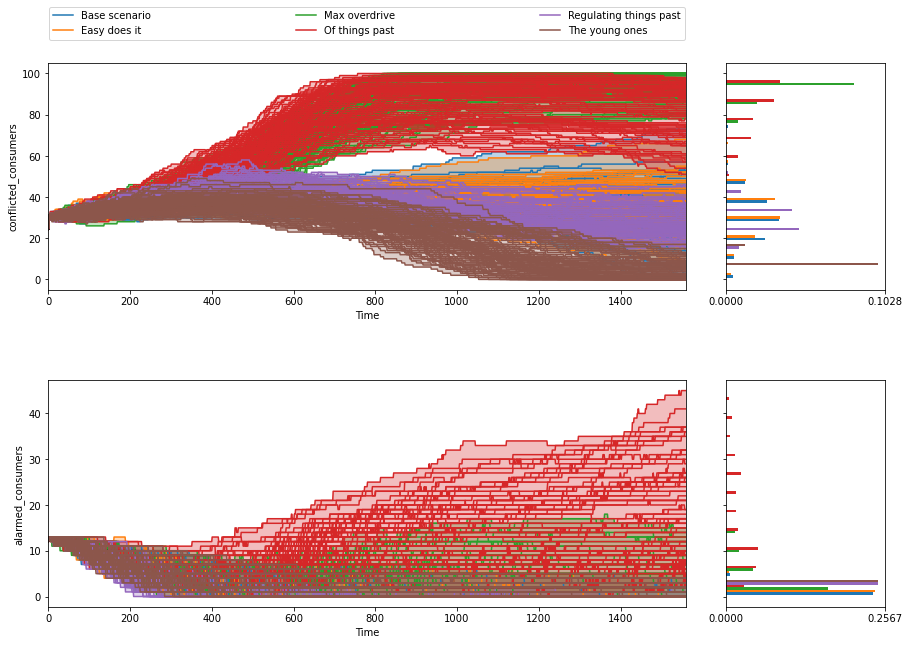

In [54]:
experiments_to_show = np.arange(0, all_experiments.shape[0], 1)

fig, ax = plotting.lines(all_experiments, 
                         all_outcomes, 
                         outcomes_to_show=['conflicted_consumers', 
                                           'alarmed_consumers'], 
                         group_by='scenario',
                         show_envelope=True, 
                         density=plotting.Density.HIST, 
                         titles=None, 
                         experiments_to_show=experiments_to_show)

fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

## Farmers

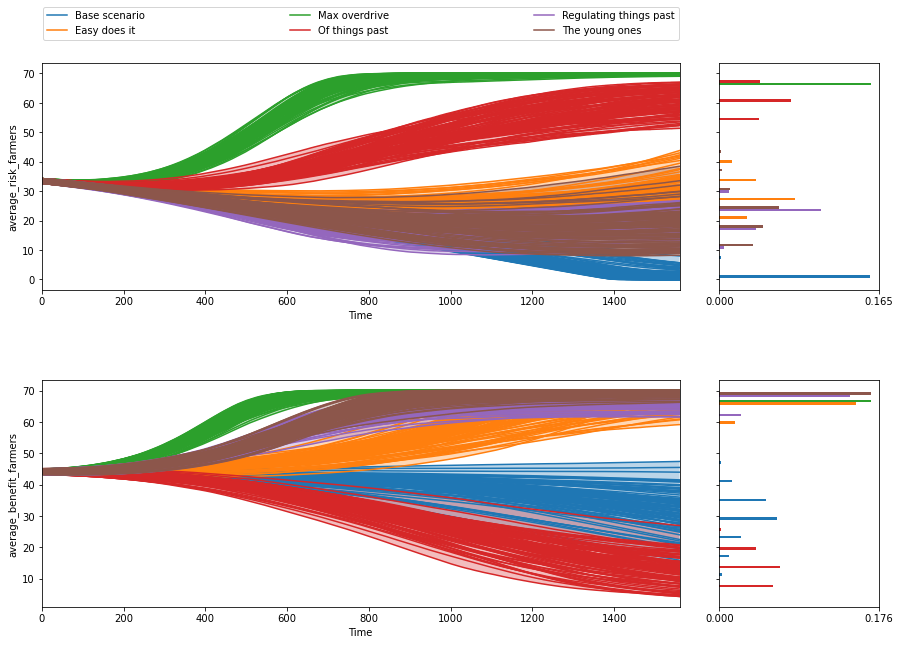

In [55]:
experiments_to_show = np.arange(0, all_experiments.shape[0], 1)

fig, ax = plotting.lines(all_experiments, 
                         all_outcomes, 
                         outcomes_to_show=['average_risk_farmers', 
                                           'average_benefit_farmers'], 
                         group_by='scenario',
                         show_envelope=True, 
                         density=plotting.Density.HIST, 
                         titles=None, 
                         experiments_to_show=experiments_to_show)

fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

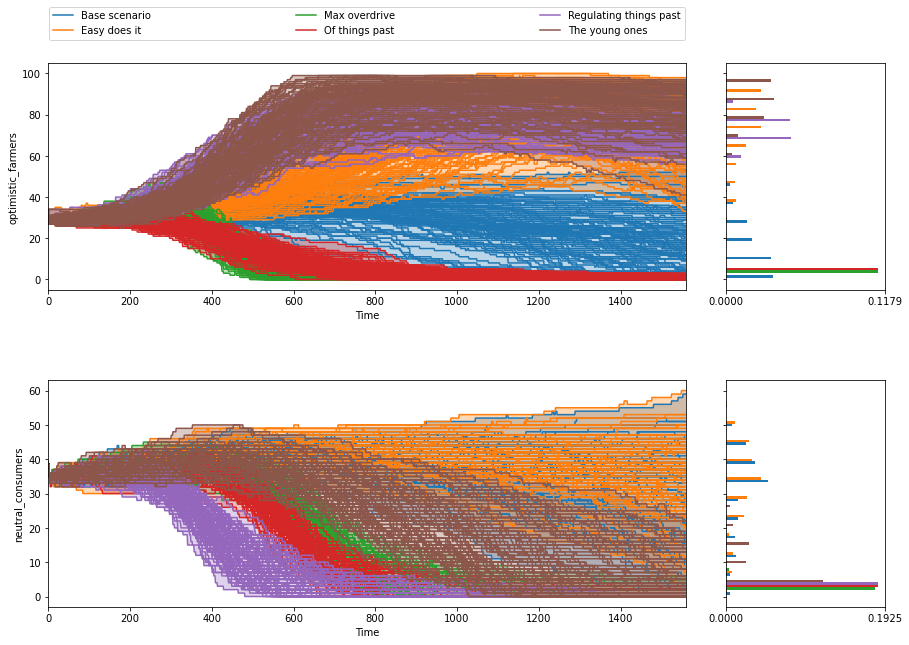

In [56]:
experiments_to_show = np.arange(0, all_experiments.shape[0], 1)

fig, ax = plotting.lines(all_experiments, 
                         all_outcomes, 
                         outcomes_to_show=['optimistic_farmers', 
                                           'neutral_consumers'], 
                         group_by='scenario',
                         show_envelope=True, 
                         density=plotting.Density.HIST, 
                         titles=None, 
                         experiments_to_show=experiments_to_show,
                         )

fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

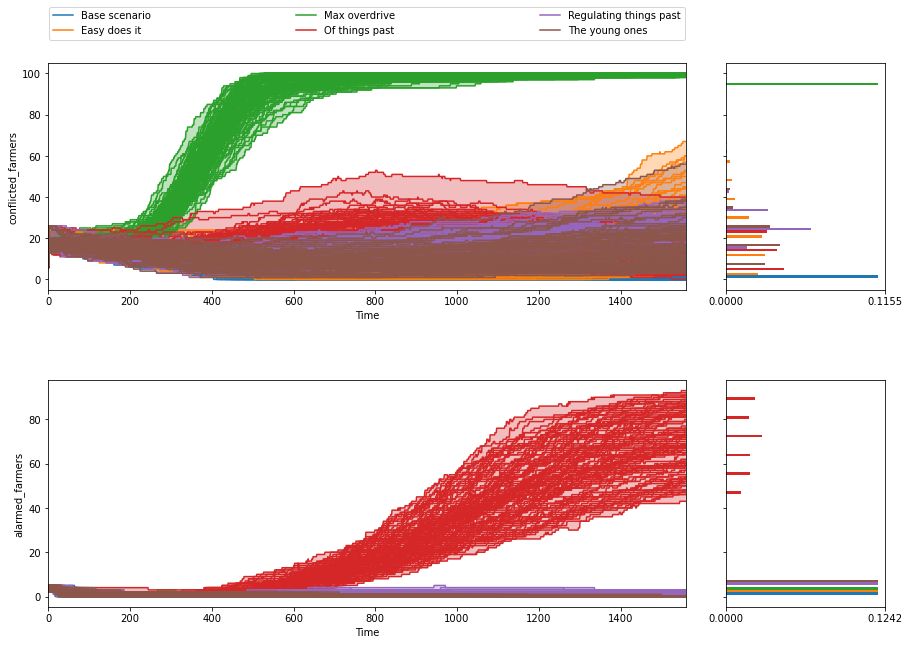

In [57]:
experiments_to_show = np.arange(0, all_experiments.shape[0], 1)

fig, ax = plotting.lines(all_experiments, 
                         all_outcomes, 
                         outcomes_to_show=['conflicted_farmers', 
                                           'alarmed_farmers'], 
                         group_by='scenario',
                         show_envelope=True, 
                         density=plotting.Density.HIST, 
                         titles=None, 
                         experiments_to_show=experiments_to_show,
                         )

fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

# Sensitivity analysis

## Scenario discovery

In [58]:
from ema_workbench.analysis import prim, feature_scoring

In [59]:
x = all_experiments.drop([c for c in ["scenario", "policy", "model"]], axis=1)
x

,Leader_network_size,consumer_leaders,farmer_leaders,leader_influence
0,8.0,0.138903,0.165749,6.0
1,9.0,0.052441,0.140762,5.0
2,7.0,0.230088,0.002777,2.0
3,11.0,0.098679,0.127905,8.0
4,9.0,0.196854,0.153421,2.0
...,...,...,...,...
595,10.0,0.239094,0.121871,2.0
596,10.0,0.058439,0.160115,2.0
597,9.0,0.148908,0.199237,10.0
598,9.0,0.029544,0.143732,1.0


In [60]:
# we have timeseries so we need scalars
y = {'average_risk_consumers': all_outcomes['average_risk_consumers'][:, -1],
     'average_benefit_consumers': all_outcomes['average_benefit_consumers'][:, -1],
     'average_risk_farmers': all_outcomes['average_risk_farmers'][:, -1],
     'average_benefit_farmers': all_outcomes['average_benefit_farmers'][:, -1],
     'optimistic_consumers': all_outcomes['optimistic_consumers'][:, -1],
     'conflicted_consumers': all_outcomes['conflicted_consumers'][:, -1],
     'neutral_consumers': all_outcomes['neutral_consumers'][:, -1],
     'alarmed_consumers': all_outcomes['alarmed_consumers'][:, -1],
     'optimistic_farmers': all_outcomes['optimistic_farmers'][:, -1],
     'conflicted_farmers': all_outcomes['conflicted_farmers'][:, -1],
     'neutral_farmers': all_outcomes['neutral_farmers'][:, -1],
     'alarmed_farmers': all_outcomes['alarmed_farmers'][:, -1],
     }

In [61]:
y_threshold = y['average_risk_consumers'] > 35
y_threshold.shape

(600,)

In [62]:
prim_alg = prim.Prim(x, y_threshold, threshold=0.2)
box = prim_alg.find_box()

[MainProcess/INFO] 600 points remaining, containing 226 cases of interest
[MainProcess/INFO] mean: 0.6875, mass: 0.05333333333333334, coverage: 0.09734513274336283, density: 0.6875 restricted_dimensions: 4


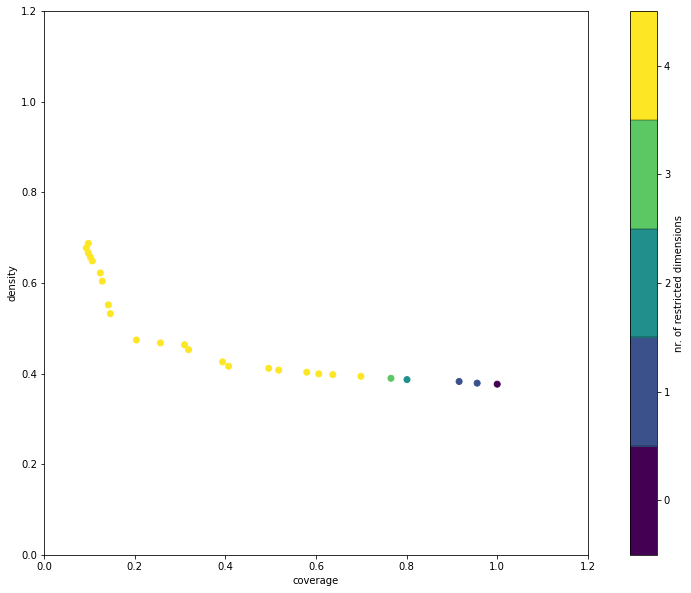

In [63]:
box.show_tradeoff()
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.show()

### The PRIM analysis shows that the cases with 'average_risk_consumers' > 35 cannot be explained with the uncertainty variables, so we can conclude that it is because of the scenarios.

## Feature Scoring

### The PRIM analysis above has already shown that the uncertainties do not explain the 

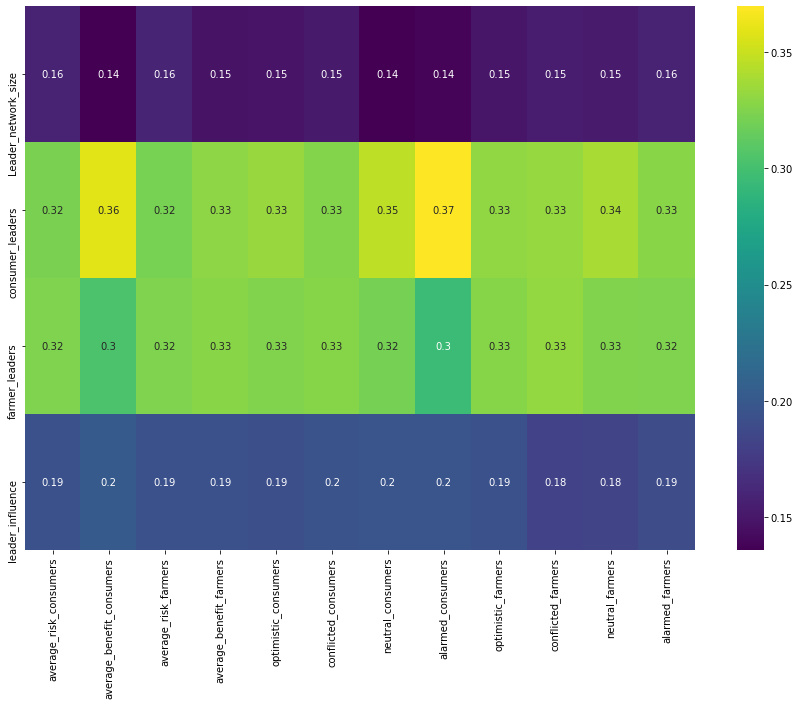

In [64]:
fig, ax = plt.subplots(figsize=(15,10))
scores = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(scores, annot=True, cmap='viridis', ax=ax)

plt.show()

#### The above feature scoring chart shows that consumer_leaders has the most influence on the outcomes. However, if we look at the alarmed_consumers line plot, we can see that there are almost no consumers in the alarmed cluster. At the end of a run it is always below 5 consumers in the alarmed cluster of the 100 in the model, however, as can be seen only 10 or 11 start in the alarmed cluster. It is interesting to see what the values are of the uncertainties that influence these strugglers. 

#### With the alarmed farmers, only one starts in the alarmed cluster. I think we have misjudged how this influences the outcomes. With only one farmer in the alarmed cluster, there is no way for them to attract more farmers to the alarmed cluster.

#### It is also apparent that consumer_leaders and farmer_leaders influence the farmer clusters the same amount. It is probably due to the fact that when there are more leaders in the model, there are more consumers and farmers that will stick to their own opinion and resist the crowd. 

## PRIM analysis 2





In [65]:
y_threshold_2 = y['alarmed_consumers'] > 2
y_threshold_2.shape

(600,)

In [66]:
prim_alg_2 = prim.Prim(x, y_threshold_2, threshold=0.2)
box_2 = prim_alg_2.find_box()

[MainProcess/INFO] 600 points remaining, containing 208 cases of interest
[MainProcess/INFO] mean: 0.5652173913043478, mass: 0.07666666666666666, coverage: 0.125, density: 0.5652173913043478 restricted_dimensions: 4


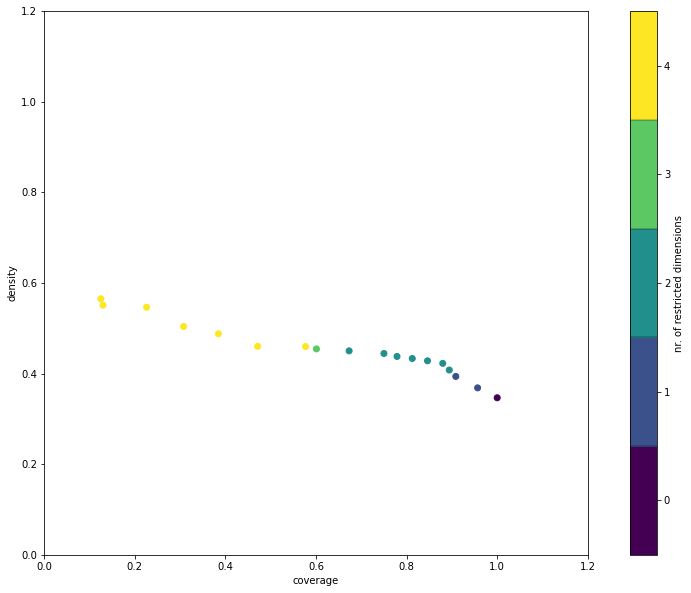

In [67]:
box_2.show_tradeoff()
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.show()

In [68]:
box_2.peeling_trajectory

,coverage,density,id,mass,mean,res_dim
0,1.000000,0.346667,0,1.000000,0.346667,0
1,0.956731,0.368519,1,0.900000,0.368519,1
2,0.908654,0.393750,2,0.800000,0.393750,1
3,0.894231,0.407895,3,0.760000,0.407895,2
4,0.879808,0.422633,4,0.721667,0.422633,2
5,0.846154,0.428224,5,0.685000,0.428224,2
6,0.812500,0.433333,6,0.650000,0.433333,2
7,0.778846,0.437838,7,0.616667,0.437838,2
8,0.750000,0.444444,8,0.585000,0.444444,2
9,0.673077,0.450161,9,0.518333,0.450161,2


#### Big jump in coverage from box 36 to 37, better to take box 36

In [69]:
box_2.inspect(37, style='graph')
plt.show()

IndexError: single positional indexer is out-of-bounds

## PRIM analysis 3

In [ ]:
y_threshold_3 = y['alarmed_farmers'] > 0
y_threshold_3.shape

In [ ]:
prim_alg_3 = prim.Prim(x, y_threshold_3, threshold=0.2)
box_3 = prim_alg_3.find_box()

In [ ]:
box_3.show_tradeoff()
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.show()

In [ ]:
box_3.peeling_trajectory

In [ ]:
box_3.inspect(1, style="graph")
plt.show()

In [ ]:
box_3.show_pairs_scatter(14)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.show()

In [ ]:
box_3.show_pairs_scatter(16)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.show()